In [1]:
pip install tensorflow_decision_forests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 13.7 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successf

In [2]:
import pandas as pd
import tensorflow_decision_forests as tfdf
import matplotlib.pyplot as plt
import numpy as np
import imblearn
import tensorflow as tf

In [3]:
train_df = pd.read_csv('../content/datasets/eval_train.csv')
test_df = pd.read_csv('../content/datasets/eval_test.csv')

In [4]:
train_df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,3,3,0,0,2,2,2
1,3,3,0,0,2,0,2
2,3,3,0,0,1,1,2
3,3,3,0,0,1,2,2
4,3,3,0,0,1,0,2


In [6]:
print("{} data utk training, {} data utk testing.".format(
    len(train_df), len(test_df)))

3944 data utk training, 327 data utk testing.


In [9]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label='class')
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, label='class')

In [10]:
tuner = tfdf.tuner.RandomSearch(num_trials=20)
tuner.choice("max_depth", [2, 3, 5, 6, 8, 10, 20])

In [18]:
model = tfdf.keras.GradientBoostedTreesModel(num_trees=500,
                                             growing_strategy="BEST_FIRST_GLOBAL",
                                             max_depth=8,
                                             split_axis="SPARSE_OBLIQUE",
                                             categorical_algorithm="RANDOM",)

#model = tfdf.keras.GradientBoostedTreesModel(num_trees=50, tuner=tuner)
training = model.fit(train_ds)

Use /tmp/tmpfqpgv5b7 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.260919. Found 3944 examples.
Training model...
Model trained in 0:00:06.341806
Compiling model...


Model compiled.


In [19]:
model.compile(metrics=['accuracy'])

evaluation = model.evaluate(test_ds, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.6f}")

1/1 [==============================] - 2s 2s/step - loss: 0.0000e+00 - accuracy: 0.9725

loss: 0.000000
accuracy: 0.972477


In [20]:
model.summary()

Model: "gradient_boosted_trees_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (6):
	buying
	doors
	lug_boot
	maint
	persons
	safety

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.   "buying"  0.369178 ################
    2.    "doors"  0.243409 #####
    3. "lug_boot"  0.242860 #####
    4.  "persons"  0.194932 #
    5.   "safety"  0.183789 
    6.    "maint"  0.181053 

Variable Importance: NUM_AS_ROOT:
    1.   "buying" 58.000000 ################
    2. "lug_boot" 49.000000 #############
    3.  "persons" 34.000000 ########
    4.    "doors" 24.000000 #####
    5.   "safety" 22.000000 #####
    6.    "maint"  5.000000 

Variable Import

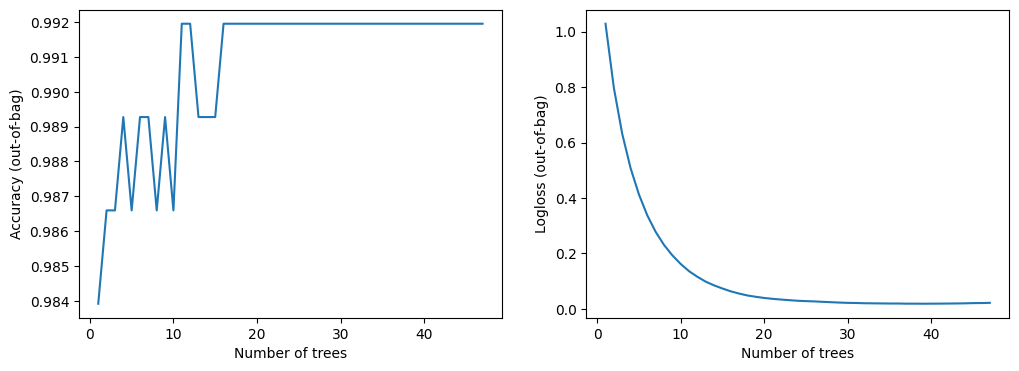

In [16]:
logs = model.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()